<a href="https://colab.research.google.com/github/alexmc1510/DAND-P5-EnronMail/blob/master/DAND_P5_Enron_Mail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identify Fraud from Enron Email

## Table of Contents
1. [Introduction](#1-Introduction)
2. [Data Exploration](#2-Data-Exploration)
3. [Outlier Investigation](#3-Outlier-Investigation)
4. [Create New Features Part I](#4-Create-New-Features-Part-I)
5. [Validation Strategy](#5-Validation-Strategy)
6. [Intelligently Select-Features](#6-Intelligently-Select-Features)
7. [Pick an Algorithm](#7-Pick-an-Algorithm)
8. [Tune the Algorithm](#8-Tune-the-Algorithm)
9. [Usage of Evaluation Metrics](#9-Usage-of-Evaluation-Metrics)
10. [Create New Features Part II](#10-Create-New-Features-Part-II)

## 1 Introduction

In this report, I will use machine learning to build a person of interest (POI) identifier based on Enron financial and email data made public as a result of the Enron scandal.

I will start by exploring the data set and investigating outliers. Then I will build the POI identifier following the process of feature selection/engineering, algorithm picking/tuning, validation, evaluation.

In [0]:
import pickle
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
# Change figure size into 8 by 6 inches
matplotlib.rcParams['figure.figsize'] = (8, 6)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib


## 2 Data Exploration

Q: Student response addresses the most important characteristics of the dataset and uses these characteristics to inform their analysis. Important characteristics include:
- total number of data points
- allocation across classes (POI/non-POI)
- number of features
- are there features with many missing values? etc.

A: There are 146 data points in the dataset.

Out of the 146 data points, there are 18 of them are identified as POIs, and the rest 128 are non-POIs.

Each data point consists the name of the person and 21 features (1 POI flag, 14 financial features and 6 email features). All financial features have real number values, and all email features except email_address feature (string value) have integer values.

All features have missing values (tabulated below). I notice there is a large difference in terms of percentages of missing values between POIs and non_POIs. By imputing the missing values with 0, I get to preserve this distinction. In other words, after imputing, a value of 0 gives different probability of being a POI than being a non-POI.

In [0]:
# Load the dataset
with open('final_project_dataset.pkl', 'rb') as data_file:
    data_dict = pickle.load(data_file)

In [0]:
# Total number of data points
print('There are {} people in the dataset.'.format(len(data_dict)))

There are 146 people in the dataset.


In [0]:
# Allocation across classes (POI/non-POI)
poi_counts = defaultdict(int)
for features_values in data_dict.values():
    poi_counts[features_values['poi']] += 1
print('There are {} POIs and {} non-POIs.'.format(poi_counts[True], poi_counts[False]))

There are 18 POIs and 128 non-POIs.


In [0]:
# Number of features
print('There are {} features.'.format(len(list(data_dict.values())[0])))
# Names of features
list(list(data_dict.values())[0].keys())

There are 21 features.


['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'email_address',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'restricted_stock',
 'director_fees']

In [0]:
# Features with missing values
nan_counts_poi = defaultdict(int)
nan_counts_non_poi = defaultdict(int)
for data_point in data_dict.values():
    if data_point['poi'] == True:
        for feature, value in data_point.items():
            if value == "NaN":
                nan_counts_poi[feature] += 1
    elif data_point['poi'] == False:
        for feature, value in data_point.items():
            if value == "NaN":
                nan_counts_non_poi[feature] += 1
    else:
        print('Got an uncategorized person.')
nan_counts_df = pd.DataFrame([nan_counts_poi, nan_counts_non_poi]).T
nan_counts_df = nan_counts_df.fillna(value=0)
nan_counts_df.columns = ['# NaN in POIs', '# NaN in non-POIs']
nan_counts_df['# NaN total'] = nan_counts_df['# NaN in POIs'] + \
                               nan_counts_df['# NaN in non-POIs']
nan_counts_df['% NaN in POIs'] = nan_counts_df['# NaN in POIs'] / \
                                          poi_counts[True] * 100
nan_counts_df['% NaN in non-POIs'] = nan_counts_df['# NaN in non-POIs'] / \
                                          poi_counts[False] * 100
nan_counts_df['% NaN total'] = nan_counts_df['# NaN total'] / \
                                          len(data_dict) * 100
    
nan_counts_df

,# NaN in POIs,# NaN in non-POIs,# NaN total,% NaN in POIs,% NaN in non-POIs,% NaN total
bonus,2.0,62.0,64.0,11.111111,48.43750,43.835616
deferral_payments,13.0,94.0,107.0,72.222222,73.43750,73.287671
deferred_income,7.0,90.0,97.0,38.888889,70.31250,66.438356
director_fees,18.0,111.0,129.0,100.000000,86.71875,88.356164
email_address,0.0,35.0,35.0,0.000000,27.34375,23.972603
exercised_stock_options,6.0,38.0,44.0,33.333333,29.68750,30.136986
expenses,0.0,51.0,51.0,0.000000,39.84375,34.931507
from_messages,4.0,56.0,60.0,22.222222,43.75000,41.095890
from_poi_to_this_person,4.0,56.0,60.0,22.222222,43.75000,41.095890
from_this_person_to_poi,4.0,56.0,60.0,22.222222,43.75000,41.095890


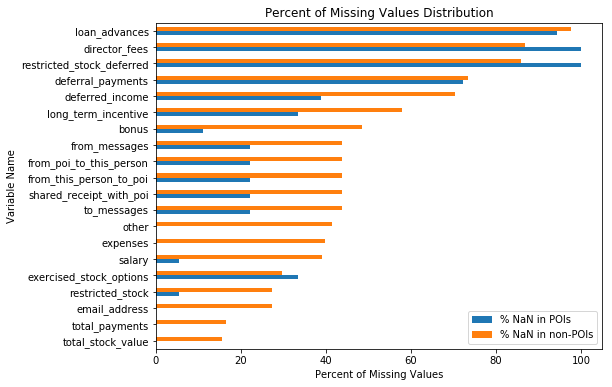

In [0]:
# Plot missing values distribution
ax = nan_counts_df.sort_values('# NaN total')[['% NaN in POIs', '% NaN in non-POIs']].plot(kind='barh', 
                                                                                    stacked=False)
ax.set_title('Percent of Missing Values Distribution')
ax.set_xlabel('Percent of Missing Values')
ax.set_ylabel('Variable Name')

## 3 Outlier Investigation

Q: Student response identifies outlier(s) in the financial data, and explains how they are removed or otherwise handled. Outliers are removed or retained as appropriate.

A: By examing the financial features, I found out two kinds of outliers.

The first kind is a data point with name 'TOTAL', and it is probably because when the dataset was generated from some spreadsheet, the summary row corresponding to the sum was also included. I removed this 'TOTAL' data point from my analysis. 

The other outliers consist of people with extreme large values of financial features. Since these values are accurate and some of them are acutally POIs, I retained these data points.

In [0]:
def allFeaturesFormat(data_dict):
    '''Convert the data dictionary with all features to a pandas DataFrame.
    
    'NaN' is filled with 0.
    
    Arg:
    data_dict: A dictionry containing all features for the enron data
    
    return:
    df: A pandas DataFrame
    '''
    temp_list = []
    for name, features_values in data_dict.items():
        temp_dict = {}
        temp_dict['name'] = name
        for feature, value in features_values.items():
            if feature in ['poi', 'email_address']:
                temp_dict[feature] = value
            else:
                if value == 'NaN':
                    value = 0
                temp_dict[feature] = float(value)
        temp_list.append(temp_dict)
    df = pd.DataFrame(temp_list)
    return df

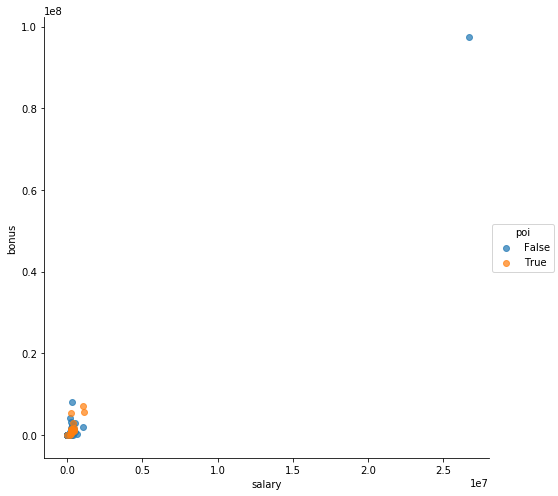

In [0]:
df = allFeaturesFormat(data_dict)
g = sns.FacetGrid(df, hue='poi', size=7)
g.map(plt.scatter, 'salary', 'bonus', alpha=.7)
g.add_legend()

In [0]:
# Remove the outlier "total"
data_dict.pop('TOTAL', 0)

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

## 4 Create New Features Part I

Q: At least one new feature is implemented. Justification for that feature is provided in the written response, and the effect of that feature on the final algorithm performance is tested.

A: Three new features are created:

The features **fraction_from_poi** and **fraction_to_poi** are the fractions of messages the persion receives from/sends to a POI. These two features measure the degree of how the persion is connected to POIs, and someone who is more connected with POIs, this person should have a higher probablity being a POI him/herself.

The feature **payments_stock_total** measures the sum of total payments and stock values. A POI should have a higher payments_stock_total comparing to a non-POI in general.

Out of the 3 new features, fraction_to_poi are the highest scored feature of the final AdaBoost based model with 7 features selected by decision tree method. The effect of this new feature on the final algorithm is tested at Create New Features Part 2 near the end of the report.

In [0]:
def computeFraction(poi_messages, all_messages):
    '''Calculate the fraction of one person's messages to/from POIs.
    
    Arg:
    poi_messages: Number of messages to/from POIs
    all_messages: Total number of messages send/receive
    
    Return:
    fraction: The fraction of messages to/from that person that are from/to POIs
    
    '''
    fraction = 0
    if poi_messages != "NaN" and all_messages != "NaN":
        fraction = poi_messages / all_messages
    return fraction

def computeTotal(total_payments, total_stock_value):
    '''Calculate the sum of total payments and total stock value
    
    Arg:
    total_payments: Total payments of a given person
    total_stock_value: Total stock value of a given person
    
    Return:
    total: The sum of these two values
    '''
    if total_payments == "NaN":
        total_payments = 0
    if total_stock_value == "NaN":
        total_stock_value = 0
    total = total_payments + total_stock_value
    return total

for data_point in data_dict.values():    
    # Create feature fraction_from_poi
    from_poi_to_this_person = data_point['from_poi_to_this_person']
    to_messages = data_point['to_messages']
    fraction_from_poi = computeFraction(from_poi_to_this_person, to_messages)
    data_point['fraction_from_poi'] = fraction_from_poi

    # Create feature fraction_to_poi
    from_this_person_to_poi = data_point['from_this_person_to_poi']
    from_messages = data_point['from_messages']
    fraction_to_poi = computeFraction(from_this_person_to_poi, from_messages)
    data_point['fraction_to_poi'] = fraction_to_poi
    
    # Create feature payments_stock_total
    total_payments = data_point['total_payments']
    total_stock_value = data_point['total_stock_value']
    data_point['payments_stock_total'] = computeTotal(total_payments, total_stock_value)

In [0]:
# Prepare features and labels for machine learning

df = allFeaturesFormat(data_dict)
# Subset dataframe with only numeric columns as features
features = df.drop(['poi', 'name', 'email_address'], axis=1)
# Labels are the 'poi' column
labels = df.poi

## 5 Validation Strategy

Q: Response addresses what validation is and why it is important.

Performance of the final algorithm selected is assessed by splitting the data into training and testing sets or through the use of cross validation, noting the specific type of validation performed.

A: Validation is the process of giving estimate of model performance on a dataset independent of training dataset. Validation can serve as a check on overfitting, and it also can help assess how well the trained model will generalize for unseen datasets.

In [0]:
# First Attempt Split #

# Split the whole dataset into stratified training/validation and test sets
# Training/validation set is used for building the model
# Test set is reserved for final model assessment

# Step 1:
# Split the whole dataset into training/validation set and test set
# features_train_validation, features_test, labels_train_validation, labels_test = \
#    train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)
    
# Step 2: 
# Split the training/validation set further into training set and validation set using StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=1000, test_size=0.3, random_state=42)

After buidling and tuning the model on my training/validation set, I assess my model performance on my reserved test set. Due to the limited amount of data in the dataset and the imbalance of number of POIs versus non-POIs, my test set ends up with only about 5 POIs. And depending on which few POIs are assigned to test set, the evaluation metrics scores vary a lot.

For obtaining more stable evaluation metrics scores from this imbalanced small dataset, I use StratifiedShuffleSplit to random split the whole dataset, and use the whole dataset for both buidling the model and assessing the model. I understand by doing this the metrics scores I obtain will be over optimistic as the model have actually seen the test set during training.

In [0]:
# Second Attempt Split #
# Split the whole data set into two sets
# They will be used as training set and validation set during model selection
# They will be used as training set and test set during model evaluation
sss = StratifiedShuffleSplit(n_splits=1000, test_size=0.3, random_state=42)

## 6 Intelligently Select Features

Q: Univariate or recursive feature selection is deployed, or features are selected by hand (different combinations of features are attempted, and the performance is documented for each one). Features that are selected are reported and the number of features selected is justified. For an algorithm that supports getting the feature importances (e.g. decision tree) or feature scores (e.g. SelectKBest), those are documented as well.

A: Two different methods are attempted to select features: SelectKBest method and DecisionTree method. Both methods generate a score for the importance of each feature, and the results are listed below. The process of determing the optimal number of features is combined with the algorithm selection process in the next section.

In [0]:
def feature_scores(features, labels, cv, selector, score_attr):
    '''Calulate the average feature scores for each feature
    
    Arg:
    features: The features DataFrame
    labels: The labels array
    cv: A cross-validation scheme
    selector: Feature selection method
    score_attr: Name of the feature importance score for the givien feature selection method
    
    Return:
    feature_scores_avg: A dictionary containing the average feature scores for each feature
    '''
    feature_names = features.columns.values
    feature_scores = defaultdict(list)
    
    for train_indices, test_indices in cv.split(features, labels):
        
        features_train = features.values[train_indices]
        features_test = features.values[test_indices]
        labels_train = labels.values[train_indices]
        labels_test = labels.values[test_indices]

        slct = selector
        slct.fit(features_train, labels_train)
        
        for feature_name, feature_score in zip(feature_names, getattr(slct, score_attr)):
            feature_scores[feature_name].append(feature_score)
    
    feature_scores = pd.DataFrame(feature_scores)
    feature_scores_avg = feature_scores.mean()
    feature_scores_avg = feature_scores_avg.sort_values(ascending=False)
    return feature_scores_avg

In [0]:
# SelectKBest method
selector = SelectKBest(k='all')
feature_scores_avg = feature_scores(features, labels, sss, selector, 'scores_')
display(feature_scores_avg)
features_selectKBest_all = list(feature_scores_avg.index)

exercised_stock_options      18.493429
total_stock_value            18.182783
bonus                        16.383794
salary                       13.908554
payments_stock_total         13.467621
fraction_to_poi              12.862240
deferred_income               9.301944
long_term_incentive           8.556530
restricted_stock              7.808638
shared_receipt_with_poi       6.868314
total_payments                6.472573
loan_advances                 5.300180
expenses                      5.071547
from_poi_to_this_person       4.656049
other                         3.696014
fraction_from_poi             2.849147
from_this_person_to_poi       2.417749
to_messages                   1.697960
director_fees                 1.512939
deferral_payments             0.300372
restricted_stock_deferred     0.269041
from_messages                 0.235749
dtype: float64

In [0]:
# DecisionTree method
selector = DecisionTreeClassifier()
feature_scores_avg = feature_scores(features, labels, sss, selector, 'feature_importances_')
display(feature_scores_avg)
features_decicionTree_all = list(feature_scores_avg.index)

fraction_to_poi              0.153008
exercised_stock_options      0.114116
expenses                     0.109379
bonus                        0.107362
other                        0.083543
shared_receipt_with_poi      0.070184
deferred_income              0.054737
total_stock_value            0.052724
total_payments               0.035533
restricted_stock             0.034291
payments_stock_total         0.030360
long_term_incentive          0.027930
salary                       0.025685
from_poi_to_this_person      0.023075
from_this_person_to_poi      0.020720
from_messages                0.019471
fraction_from_poi            0.016332
to_messages                  0.011023
deferral_payments            0.008664
restricted_stock_deferred    0.001293
loan_advances                0.000570
director_fees                0.000000
dtype: float64

## 7 Pick an Algorithm

Q: At least 2 different algorithms are attempted and their performance is compared, with the more performant one used in the final analysis.

A: Three algorithms are attempted: Naive Bayes, AdaBoost, Random Forest. For each algorithm, evaluation metrics: accuracy, precision, recall and f1 score are calculated for varying number of features from SelectKBest and DecisionTree methods.

The rationale behind combining feature selection and algorithm picking is due to lack of definite cutoff threshold for number of features to keep. Therefore, I decide to calculate metrics for each algorithm with different number of features by included features starting from the highest score feature to the lowest. And the combination of algorithm and number of features that gives the highest f1 score will be my final model candidate.

In [0]:
def metrics_scores(features_n, labels, cv, clf):
    '''Calculate accuracy, precision, recall, f1 score and f2 score for a given model
    
    Args:
    features_n: A subset of features DataFrame containing n features
    labels: The labels array
    cv: A cross-validation scheme
    clf: A classifier method
    
    Return:
    (accuracy, precision, recall, f1, f2): A tuple containing evaluation metric scores
    '''
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0

    for train_indices, test_indices in cv.split(features_n, labels):

        features_train = features_n.values[train_indices]
        features_test = features_n.values[test_indices]
        labels_train = labels.values[train_indices]
        labels_test = labels.values[test_indices]

        clf.fit(features_train, labels_train)
        labels_pred = clf.predict(features_test)

        for prediction, truth in zip(labels_pred, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1

    total_predictions = true_negatives+false_negatives+false_positives+true_positives
    accuracy = (true_positives+true_negatives)/total_predictions
    precision = true_positives/(true_positives+false_positives)
    recall = true_positives/(true_positives+false_negatives)
    f1 = 2*true_positives/(2*true_positives+false_positives+false_negatives)
    f2 = (1+2*2)*precision*recall/(4*precision+recall)

    return (accuracy, precision, recall, f1, f2)

def feature_num_scores(features, labels, feature_names_by_score, cv, clf):
    '''Calculate and plot evaluation metrics vs number of features for a given model
    
    Arg:
    features: The features DataFrame
    labels: The labels array
    feature_names_by_score: Feature names in descending order of feature importance scores
    cv: A cross-validation scheme
    clf: A classifier method
    
    Return:
    scores_df: A DataFrame containing evaluation metrics vs number of features
    '''
    num_features_accuracy_scores = []
    num_features_percision_scores = []
    num_features_recall_scores = []
    num_features_f1_scores = []
    
    for n in range(len(feature_names_by_score)):
        
        # Subset n features with the n highest feature scores
        features_n = features[feature_names_by_score[:n+1]]
        
        accuracy, precision, recall, f1, _ = metrics_scores(features_n, labels, cv, clf)
        
        num_features_accuracy_scores.append(accuracy)
        num_features_percision_scores.append(precision)
        num_features_recall_scores.append(recall)
        num_features_f1_scores.append(f1)
        
    scores_df = pd.DataFrame({
            'Number of features': range(1, len(num_features_accuracy_scores)+1),
            'Accuracy': num_features_accuracy_scores,
            'Precision': num_features_percision_scores,
            'Recall': num_features_recall_scores,
            'f1': num_features_f1_scores
        })
    
    scores_df.plot(x='Number of features', xticks=range(1, len(num_features_accuracy_scores)+1))
    return scores_df

In [0]:
# Due to running time, 100 shuffles are used instead of 1000 shuffles for algorithm selection
sss_100 = StratifiedShuffleSplit(n_splits=100, test_size=0.3, random_state=42)

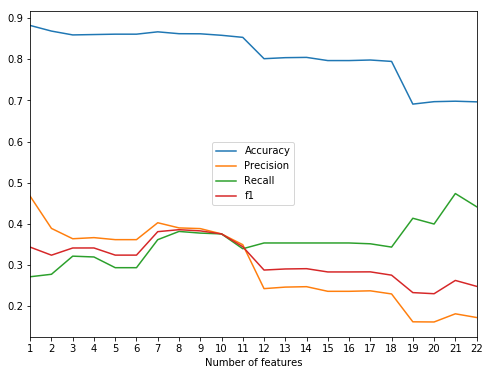

In [0]:
# Naive Bayes with SelectKBest features
clf = GaussianNB()
scores_NaiveBayes_SelectKBest_df = feature_num_scores(features, labels, features_selectKBest_all, sss_100, clf)

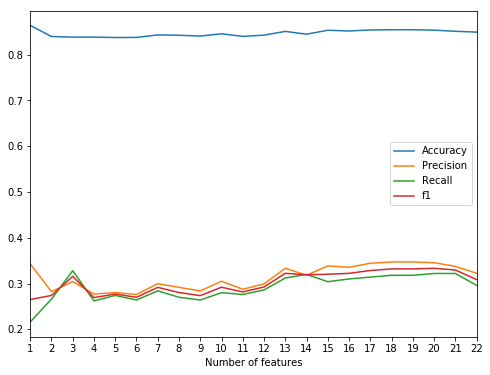

In [0]:
# AdaBoost with SelectKBest features
clf = AdaBoostClassifier()
scores_AdaBoost_SelectKBest_df = feature_num_scores(features, labels, features_selectKBest_all, sss_100, clf)

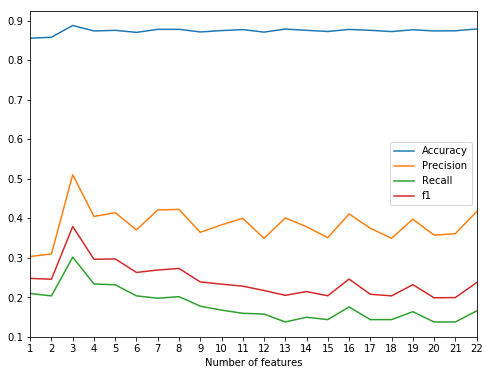

In [0]:
# Random Forest with SelectKBest features
clf = RandomForestClassifier()
scores_RandomForest_SelectKBest_df = feature_num_scores(features, labels, features_selectKBest_all, sss_100, clf)

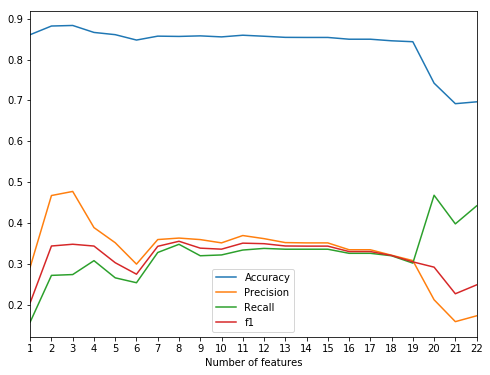

In [0]:
# Naive Bayes with DecisionTree features
clf = GaussianNB()
scores_NaiveBayes_DecisionTree_df = feature_num_scores(features, labels, features_decicionTree_all, sss_100, clf)

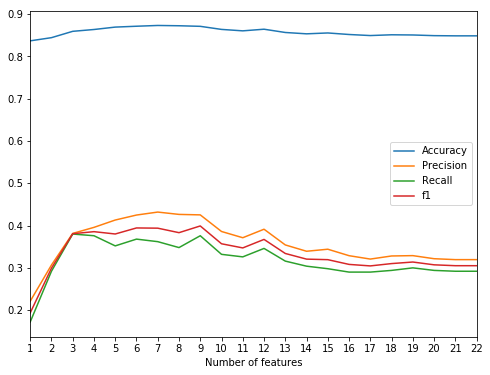

In [0]:
# AdaBoost with DecisionTree features
clf = AdaBoostClassifier()
scores_AdaBoost_DecisionTree_df = feature_num_scores(features, labels, features_decicionTree_all, sss_100, clf)

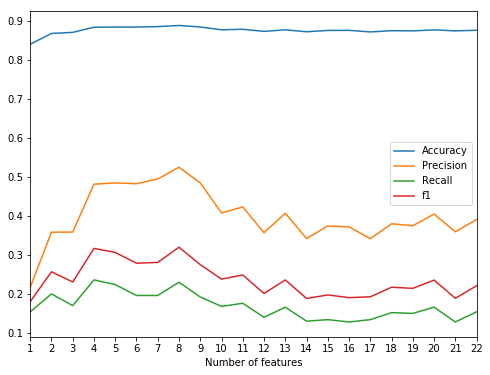

In [0]:
# Random Forest with decisionTree features
clf = RandomForestClassifier()
scores_RandomForest_DecisionTree_df = feature_num_scores(features, labels, features_decicionTree_all, sss_100, clf)

f1 scores will be used to select the best model. f1 scores provide a balance of false positive rate and false negative rate in our case.

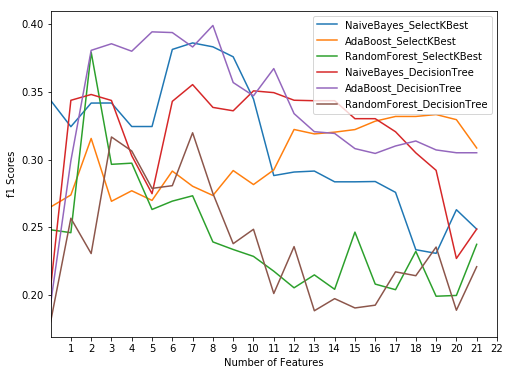

In [0]:
# Plot f1 scores of all previous 6 combinations of classifier methods and feature selection methods
f1_df = pd.DataFrame([scores_NaiveBayes_SelectKBest_df['f1'], 
                     scores_AdaBoost_SelectKBest_df['f1'],
                     scores_RandomForest_SelectKBest_df['f1'],
                     scores_NaiveBayes_DecisionTree_df['f1'],
                     scores_AdaBoost_DecisionTree_df['f1'],
                     scores_RandomForest_DecisionTree_df['f1']]).T
f1_df.columns = ['NaiveBayes_SelectKBest',
                'AdaBoost_SelectKBest',
                'RandomForest_SelectKBest',
                'NaiveBayes_DecisionTree',
                'AdaBoost_DecisionTree',
                'RandomForest_DecisionTree']
ax = f1_df.plot(xticks=arange(1, f1_df.shape[0]+1))
ax.set_xlabel('Number of Features')
ax.set_ylabel('f1 Scores')

Out of the three algorithms tested without tuning, AdaBoost with 8 features selected using decision tree because it gives the best f1 score.

In [0]:
features_DecisionTree_8 = features_decicionTree_all[:8]
display("Features selected for AdaBoost model:", features_decisionTree_8)

'Features selected for AdaBoost model:'

['fraction_to_poi',
 'exercised_stock_options',
 'expenses',
 'bonus',
 'other',
 'shared_receipt_with_poi',
 'deferred_income',
 'total_stock_value']

## 8 Tune the Algorithm 

Q: Response addresses what it means to perform parameter tuning and why it is important.

At least one important parameter tuned, with at least 3 settings investigated systematically, or any of the following are true:
- GridSearchCV used for parameter tuning
- Several parameters tuned
- Parameter tuning incorporated into algorithm selection (i.e. parameters tuned for more than one algorithm, and best algorithm-tune combination selected for final analysis)

A: To perform parameter tuning menas to search for optimized parameters for a given algorithm in order to optimize the performance of the model to our specific problem.

It is an important part of machine learning, because tuning the parameters can result in increased performance, such as achieving higher evalution metrics and reducing overfitting of the model.

I will use GridSearchCV to tune the parameters.

In [0]:
param_grid = dict(base_estimator__max_depth = [None, 1, 3, 5],
                  base_estimator__class_weight = [None, 'balanced'],
                  n_estimators = [25, 50, 100])
gs = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), 
                                                random_state=42),
                   param_grid=param_grid,
                   scoring='f1', 
                   cv=sss_100)
gs.fit(features[features_DecisionTree_8], labels)
clf = gs.best_estimator_

In [0]:
# Grid scores
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
scores_df = pd.DataFrame([means, stds]).T
scores_df.columns = ['mean_test_score', 'std_test_score']
params_df = pd.DataFrame(gs.cv_results_['params'])
grid_scores_df = pd.concat([scores_df, params_df], axis=1)
grid_scores_df.sort_values('mean_test_score', ascending=False)

,mean_test_score,std_test_score,base_estimator__class_weight,base_estimator__max_depth,n_estimators
5,0.402848,0.192421,None,1.0,100
17,0.395941,0.180282,balanced,1.0,100
15,0.394769,0.169952,balanced,1.0,25
16,0.394136,0.182684,balanced,1.0,50
8,0.381473,0.198625,None,3.0,100
20,0.380978,0.203795,balanced,3.0,100
19,0.376167,0.197597,balanced,3.0,50
4,0.370708,0.173104,None,1.0,50
3,0.367049,0.180623,None,1.0,25
7,0.356947,0.195563,None,3.0,50


## 9 Usage of Evaluation Metrics

Q: At least two appropriate metrics are used to evaluate algorithm performance (e.g. precision and recall), and the student articulates what those metrics measure in context of the project task.

A: Accuracy, precision, recall and f1 score are used as metrics to evaluate the model performance. In the context of identifying POIs in Enron dataset:

- **Accuracy** measures of all the predictions made, what is the percentage of correctly identified POIs and non-POIs. The higher the accuracy, the more confident we are about the correctness of our model in general.
- **Precision** measures of all the predicted POIs, what is the percentage of them actually being real POIs. The higher precision, the more confident we are about the correctness of identified POIs in our prediction (high precision, low false positive rate).
- **Recall** measures of all the real POIs in the dataset, what is the percetage of them being identified as POIs.The higher recall, the more confident we are about recover more POIs (signal) from non-POIs (noise) (high recall, low false negative rate).
- **F1** score gives a harmonic mean of precision and recall.

In [0]:
def display_metrics(accuracy, precision, recall, f1, f2):
    '''Display metrics scores
    
    Arg:
    accuracy: Accuracy score
    precision: Precision Score
    recall: Recall score
    f1: f1 score
    f2: f2 score
    '''
    
    PERF_FORMAT_STRING = "\
    Accuracy: {:>0.{display_precision}f}\n\
    Precision: {:>0.{display_precision}f}\n\
    Recall: {:>0.{display_precision}f}\n\
    F1: {:>0.{display_precision}f}\n"

    print(PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, display_precision = 5))

In [0]:
scores = metrics_scores(features[features_DecisionTree_8], labels, sss, clf)
display_metrics(*scores)

    Accuracy: 0.87361
    Precision: 0.43301
    Recall: 0.36260
    F1: 0.39469



## 10 Create New Features Part II

To examine the effect of the new feature fraction_to_poi, which also happens to be the highest importance feature during decision tree feature selection process, I'll leave out this feature and test how this will change the metrics of the final model.

In [0]:
# Leave out froaction_to_poi feature from the final model
features_DecisionTree_7 = features_decicionTree_all[1:8]
scores_without_fraction_to_poi = metrics_scores(features[features_DecisionTree_7], labels, sss, clf)
display_metrics(*scores_without_fraction_to_poi)

    Accuracy: 0.86634
    Precision: 0.39126
    Recall: 0.31700
    F1: 0.35024



In [0]:
scores_fraction_to_poi = dict(with_fraction_to_poi = scores[:-1],
                              without_fraction_to_poi = scores_without_fraction_to_poi[:-1])
df_scores = pd.DataFrame(scores_fraction_to_poi, 
                         index = ['Accuracy', 'Precision', 'Recall', 'F1'])
df_scores['percent_change(%)'] = (df_scores.without_fraction_to_poi - df_scores.with_fraction_to_poi) / \
                            df_scores.without_fraction_to_poi * 100
df_scores

,with_fraction_to_poi,without_fraction_to_poi,percent_change(%)
Accuracy,0.873614,0.866341,-0.839476
Precision,0.433007,0.391261,-10.669467
Recall,0.362600,0.317000,-14.384858
F1,0.394688,0.350238,-12.691559


As we can see, although leaving out the created fraction_to_poi feature doesn't affect the accuracy much, it does result in more than 10 percent decrease in precision, recall and f1 score.